
## Including additional information to the model

We are now adding an extra feature: additional information that we have appart 
form the image. In this example we are assuiming we have the size of the object 
or at least an estimation of the size.  

We simulate the size as normal distributions. We consider three scenarios
* No overlap between the distributions of the sizes of each class
* Partial between the distributions of the sizes of each class
* High olverlap between the distributions of the sizes of each class





In [1]:
import random
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef
from modular import model_builder

In [10]:
# Simulate data (with no noise)
n_reps = 10
n_samples = [10000] * 2

# Simulate extra feature
mu_c = np.array([-2,-1,-0.5,0])
mu_s = np.array([2,1,0.5,0])
sigma_s, sigma_c = 0.5, 0.5

# Keep accuracy test
accuracy_test = np.zeros((len(mu_c), 2 ,n_reps))

# Fix seeds
seeds = [99,999,9999,40]

# Batch size and epochs
BATCH_SIZE = 30
epochs = 5

# Loss Function
loss_fn = nn.CrossEntropyLoss()

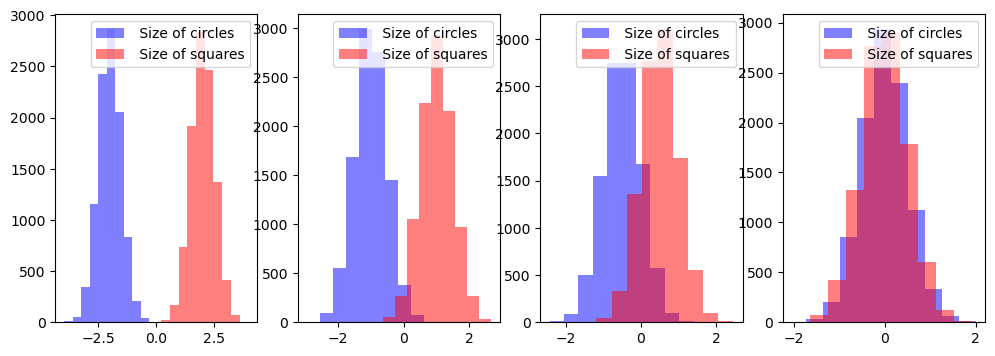

In [8]:
# Plot extra features
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(len(mu_c)):
    feature_c = np.random.normal(mu_c[i], sigma_c, n_samples)
    feature_s = np.random.normal(mu_s[i], sigma_s, n_samples)
    axes[i].hist(feature_c, label = f' Size of circles', color = 'blue', alpha = 0.5)
    axes[i].hist(feature_s, label = f' Size of squares', color = 'red', alpha = 0.5)
    axes[i].legend()



In [11]:
input_shapes = [2, 1]

for k in range(n_reps):
    # Simulate images and labels
    output = cs.generate_sample(n_samples, 0,var=0,seed= 89)
    images, labels= (output['images'], output['labels'])

    # Split test and train
    n_test = int(2*n_samples*0.2)
    test_index = np.arange(n_test)
    train_index = np.arange(n_test, n_samples*2)

    images_test = images[test_index]
    images_train = images[train_index]

    label_test = labels[test_index]
    label_train = labels[train_index]
        
    # keep indices
    indx_s = np.where(labels==1)
    indx_c = np.where(labels==0)

    for i in range(len(mu_s)):
        
        # Simulate extra feature
        random.seed(seeds[i])
        feature_c = np.random.normal(mu_c[i], sigma_c, n_samples)
        feature_s = np.random.normal(mu_s[i], sigma_s, n_samples)
        
        extra_feature = np.zeros(len(labels))
        extra_feature[indx_c] = feature_c
        extra_feature[indx_s] = feature_s 
        
        # Repeat each value as a 28x28 matrix to create channel
        ef_arr = np.tile(extra_feature[:, np.newaxis, np.newaxis], (1, 28, 28))
        ef_test = ef_arr[test_index]
        ef_train = ef_arr[train_index]
            
        # Create tensors
        X_test = torch.from_numpy(images_test).type(torch.float)
        X_train = torch.from_numpy(images_train).type(torch.float)

        F_test = torch.from_numpy(ef_test).type(torch.float)
        F_train = torch.from_numpy(ef_train).type(torch.float)

        y_train = torch.from_numpy(label_train).type(torch.long)
        y_test = torch.from_numpy(label_test).type(torch.long)

        # Combine channels 
        XF_train = torch.stack([X_train,F_train], dim=1)
        XF_test = torch.stack([X_test,F_test], dim=1)

        X_train_list = [XF_train, X_train.unsqueeze(1)]
        X_test_list = [XF_test, X_test.unsqueeze(1)]
        
        # Train and test model with and without extra feature 
        for j in range(len(X_test_list)):

            train_dataset = torch.utils.data.TensorDataset(X_train_list[j],
                                                        y_train)
            test_dataset = torch.utils.data.TensorDataset(X_test_list[j],
                                                        y_test)
            
            # Create data loader and turn datasets into iterables (batches)
            train_dataloader = DataLoader(train_dataset, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True) 

            test_dataloader = DataLoader(test_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

            # Initialize model and optimizer
            model =  model_builder.TVGG(input_shape=input_shapes[j], 
                                        hidden_units= 10, 
                                        output_shape=2)
                        
            optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
            
            # Train test loop
            output = engine.train_test_loop(model,train_dataloader,
                                            test_dataloader, optimizer, loss_fn,
                                            epochs,print_b=False)

            accuracy_test[i,j,k]  = output['test_acc'][epochs-1] 

    

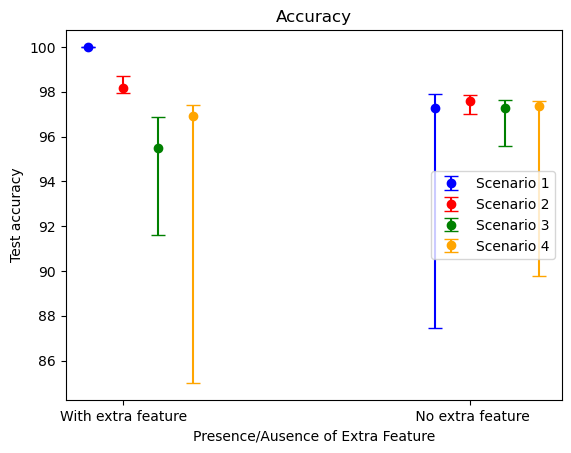

In [12]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(accuracy_test, q=quantiles, axis=2)
quantile_array.shape

x_offsets = [-0.1, 0.0, 0.1, 0.2]  # Offsets for each plot on the x-axis


binary_f = ['With extra feature',' No extra feature']

colors = np.array(['blue','red','green','orange'])

for i in range(len(mu_s)):
    lower_errors = quantile_array[1,i,] - quantile_array[0,i,]
    upper_errors = quantile_array[2,i,] - quantile_array[1,i,]

    # Combine the lower and upper errors in a single array
    asymmetric_error = [lower_errors, upper_errors]
    adjusted_x =  np.array([0,1]) + np.array(x_offsets[i])


    plt.errorbar(adjusted_x, quantile_array[1,i,], 
                yerr= asymmetric_error, fmt='o', capsize=5, color= colors[i],
                label=f'Scenario {i+1}')

plt.xticks(np.array([0,1]), ['With extra feature',' No extra feature'])


plt.xlabel('Presence/Ausence of Extra Feature')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()


# Adding noise to images 

In [102]:
n_reps = 10
n_samples = [10000] * 2

# Simulate extra feature
mu_c = np.array([-2,-1,-0.5,0])
mu_s = np.array([2,1,0.5,0])
sigma_s, sigma_c = 0.5, 0.5

# Noise 
noise_props = np.array([0,0.25,0.5,0.75,0.99])
var = 0.25

# Keep accuracy test
accuracy_test_n = np.zeros((len(mu_c), 2 ,len(noise_props),n_reps))

# Fix seeds
seeds = [99,999,9999,40]

# Batch size and epochs
BATCH_SIZE = 30
epochs = 5

# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [103]:
input_shapes = [2, 1]

for p in range(len(noise_props)):
    
    for k in range(n_reps):
        # Simulate images and labels
        output = cs.generate_sample(n_samples, noise_props[p],var=var)
        images, labels = (output['images'], output['labels'])

        # Split test and train
        n_test = int(2*n_samples*0.2)
        test_index = np.arange(n_test)
        train_index = np.arange(n_test, n_samples*2)

        images_test = images[test_index]
        images_train = images[train_index]

        label_test = labels[test_index]
        label_train = labels[train_index]
            
        # keep indices
        indx_s = np.where(labels==1)
        indx_c = np.where(labels==0)

        for i in range(len(mu_s)):
            
            # Simulate extra feature
            random.seed(seeds[i])
            feature_c = np.random.normal(mu_c[i], sigma_c, n_samples)
            feature_s = np.random.normal(mu_s[i], sigma_s, n_samples)
            
            extra_feature = np.zeros(len(labels))
            extra_feature[indx_c] = feature_c
            extra_feature[indx_s] = feature_s 
            
            # Repeat each value as a 28x28 matrix to create channel
            ef_arr = np.tile(extra_feature[:, np.newaxis, np.newaxis], (1, 28, 28))
            ef_test = ef_arr[test_index]
            ef_train = ef_arr[train_index]
                
            # Create tensors
            X_test = torch.from_numpy(images_test).type(torch.float)
            X_train = torch.from_numpy(images_train).type(torch.float)

            F_test = torch.from_numpy(ef_test).type(torch.float)
            F_train = torch.from_numpy(ef_train).type(torch.float)

            y_train = torch.from_numpy(label_train).type(torch.long)
            y_test = torch.from_numpy(label_test).type(torch.long)

            # Combine channels 
            XF_train = torch.stack([X_train,F_train], dim=1)
            XF_test = torch.stack([X_test,F_test], dim=1)

            X_train_list = [XF_train, X_train.unsqueeze(1)]
            X_test_list = [XF_test, X_test.unsqueeze(1)]
            
            # Train and test model with and without extra feature 
            for j in range(len(X_test_list)):

                train_dataset = torch.utils.data.TensorDataset(X_train_list[j],
                                                            y_train)
                test_dataset = torch.utils.data.TensorDataset(X_test_list[j],
                                                            y_test)
                
                # Create data loader and turn datasets into iterables (batches)
                train_dataloader = DataLoader(train_dataset, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True) 

                test_dataloader = DataLoader(test_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)

                # Initialize model and optimizer
                model =  model_builder.TVGG(input_shape=input_shapes[j], 
                                            hidden_units= 10, 
                                            output_shape=2)
                            
                optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
                
                # Train test loop
                output = engine.train_test_loop(model,train_dataloader,
                                                test_dataloader, optimizer, loss_fn,
                                                epochs,print_b=False)

                accuracy_test_n[i,j,p,k]  = output['test_acc'][epochs-1] 

        

In [104]:
transposed_array = np.transpose(accuracy_test_n, (3, 2, 0, 1))
transposed_array.shape
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(transposed_array, q=quantiles, axis=0)
quantile_array.shape

(3, 5, 4, 2)

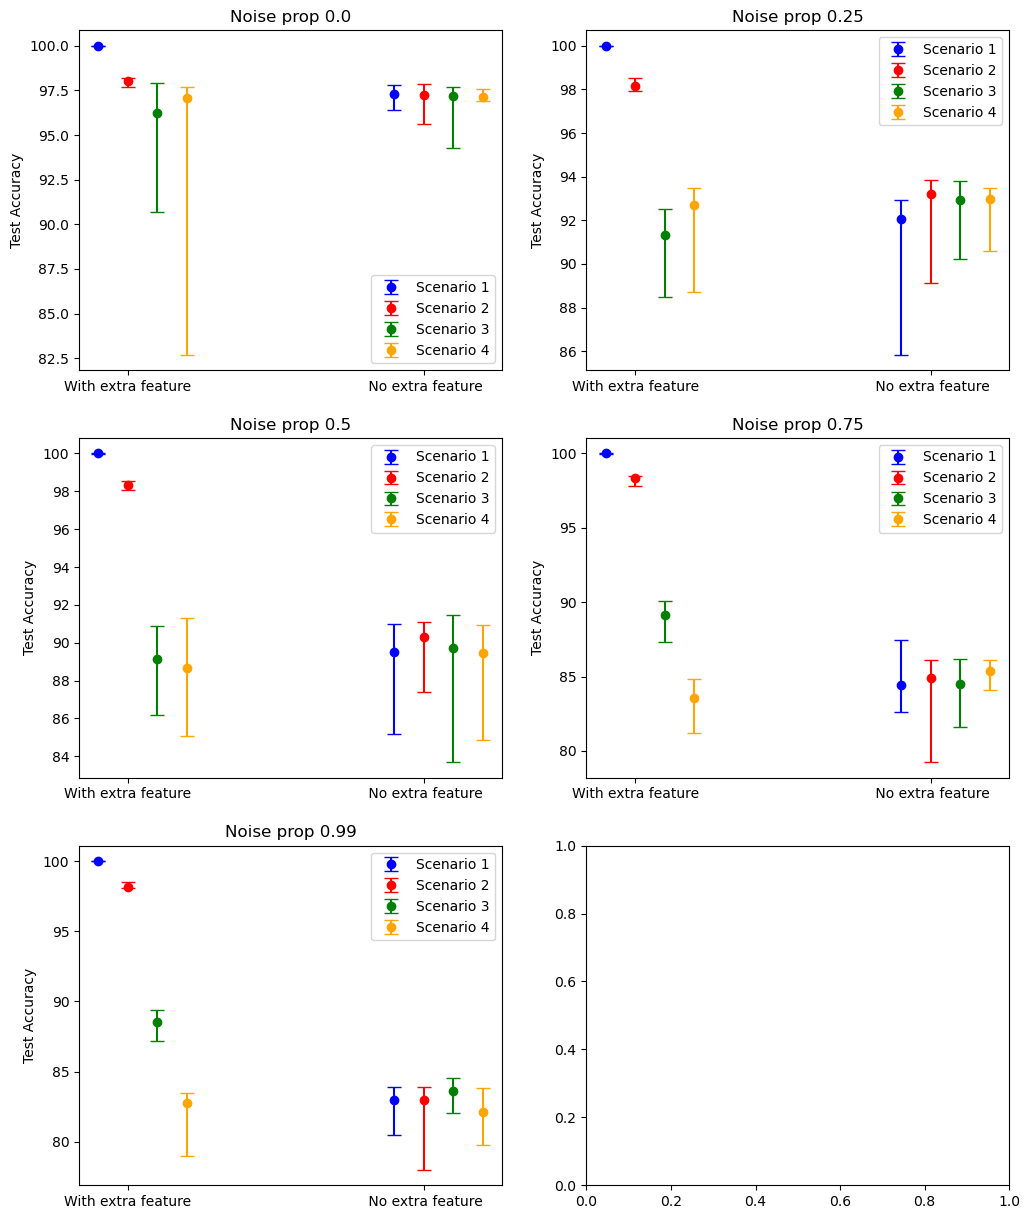

In [105]:
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th, and 90th percentiles
quantile_array = np.quantile(transposed_array, q=quantiles, axis=0)

x_offsets = [-0.1, 0.0, 0.1, 0.2]  # Offsets for each plot on the x-axis


binary_f = ['With extra feature',' No extra feature']

colors = np.array(['blue','red','green','orange'])

fig, axes = plt.subplots(3,2, figsize=(12, 15))
axes = axes.flatten()


for i in range(len(noise_props)):
   
    for j in range(len(mu_s)):
        adjusted_x =  np.array([0,1]) + np.array(x_offsets[j])
        
        lower_errors = quantile_array[1,i,j,] - quantile_array[0,i,j,]
        upper_errors = quantile_array[2,i,j,] - quantile_array[1,i,j,]

        # Combine the lower and upper errors in a single array
        asymmetric_error = [lower_errors, upper_errors]

        # axes[i].scatter(adjusted_x,transposed_array[0,i,j,],color= colors[j],
        #             label=f'Scenario {j+1}')
        
        axes[i].errorbar(adjusted_x, quantile_array[1,i,j,], 
                yerr= asymmetric_error, fmt='o', capsize=5, color= colors[j],
               label=f'Scenario {j+1}')
        axes[i].legend(['Scenario 1','Scenario 2','Scenario 3','Scenario 4'])
        axes[i].set_title(f'Noise prop {noise_props[i]}')
        axes[i].set(ylabel = 'Test Accuracy')
        axes[i].set_xticks(np.array([0,1]))  # Set x-ticks
        axes[i].set_xticklabels(['With extra feature',' No extra feature'])
        
        # plt.xticks(np.array([0,1]), ['With extra feature',' No extra feature'])
        # plt.xlabel('Presence/Ausence of Extra Feature')
        # plt.ylabel('Test accuracy')
            
     


        


## Save some environment variables usign joblib

In [113]:
import joblib
import os

env_vars = {'accuracy_test_n': os.getenv('accuracy_test_n', 'NA'),
            'n_reps': os.getenv('n_reps', 'NA'),
            'n_samples': os.getenv('n_samples', 'NA'),
            'mu_c': os.getenv('mu_c','NA'),
            "mu_s": os.getenv('mu_s','NA'),
            "sigma_s":  os.getenv('sigma_s','NA'),
            "sigma_c":  os.getenv('sigma_c','NA'),
            "noise_props": os.getenv('noise_props','NA'),
            "var": os.getenv('var','NA')
            }

joblib.dump(env_vars, './environments/including_features_Sep23.pkl')


['./environments/including_features_Sep23.pkl']

In [ ]:
# Load the environment variables from the file
# loaded_env_vars = joblib.load('./environments/including_features_Sep23.pkl')

# # Set the environment variables in the current session
# for key, value in loaded_env_vars.items():
#     os.environ[key] = value